In [150]:
library(readxl)
library(dplyr)
library(ggplot2)
library(ggh4x) # for facet_grid2() and strip_themed()
library(scales) # for percent()
library(ggtext)    # for strip_themed (theme strip customization)
library(grid)      # for unit()
library(tidyr) 
library(reshape2)
library(data.table)
library(purrr) # for looping over multiple values and combining the results into one tidy data frame

## Timing bandwidths of Sea Level Rise Thresholds
As a key driver influencing the emergence of policy thresholds in our marsh accretion model, sea level rise plays a crucial role in shaping adaptation strategies. The information on a critical sea level threshold triggering a policy tipping point, combined with the timing of such a threshold, provides essential insights for adaptation decision-making. We build on the framework proposed by Slangen et al. (2022), using timing bandwidths of sea level rise thresholds to guide decision-making. 

### Load plotting data


**Plotting data for the sea level ranges**: Raw data with pre-plot-processing performed in this notebook.

In [151]:
slr_ranges <- read.table('../data/figure_3_data/regional_slr_ar5.txt', sep = '\t', header = TRUE)[, 1:7]
slr_ranges_df = as.data.table(slr_ranges)
slr_ranges_df <- slr_ranges_df %>%
  mutate(year = as.double(year))

#### Figure 6 - middle


Converting the data table to long format with columns ``year``, ``variable`` indicating the concentration pathway (RCP) and the the choice of lower, central or upper estimate within the sea level rise uncertainty envelope, and the corresponding ``value``. 

In [152]:
melted = melt(slr_ranges_df, id.vars = "year")
slr_long=data.table(melted)
#slr_long$year <- 	as.Date(paste0(slr_long$year, "-01-01"))

In [153]:
# Set threshold values
threshold_vals <- c("0.5", "0.6", "0.8", "1.0")

slr_thr <- map_dfr(threshold_vals, function(thr) {
  slr_long %>%
    filter(value >= thr) %>%
    group_by(variable) %>%
    slice_min(order_by = value, with_ties = FALSE) %>%
    ungroup() %>%
    separate(variable, into = c("variable", "rcp"), sep = "_", remove = FALSE) %>%
    mutate(threshold = thr)%>%
    select(year, variable, rcp, threshold)
})

In [154]:
slr_thr

year,variable,rcp,threshold
<dbl>,<chr>,<chr>,<chr>
2074,mean,85,0.5
2058,max,85,0.5
2090,mean,45,0.5
2066,max,45,0.5
2083,mean,85,0.6
2066,max,85,0.6
2077,max,45,0.6
2100,mean,85,0.8
2079,max,85,0.8


In [155]:
slr_thr_wide <- slr_thr %>%
  pivot_wider(names_from = variable, values_from = year)%>%
  as.data.frame()%>%
    mutate(
    max = if_else(is.na(max), 2100, max),
    min = 2100,                            # Set constant date for min
    mean_segment = if_else(is.na(mean), 2100, mean)
  )
slr_thr_wide

rcp,threshold,mean,max,min,mean_segment
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
85,0.5,2074,2058,2100,2074
45,0.5,2090,2066,2100,2090
85,0.6,2083,2066,2100,2083
45,0.6,NA,2077,2100,2100
85,0.8,2100,2079,2100,2100
45,0.8,NA,2098,2100,2100
85,1.0,NA,2091,2100,2100


In [195]:
# To control plotting order, the factor column threshold_f with the threshold values as levels is defined
slr_thr_wide$threshold_f <- factor(slr_thr_wide$threshold, levels = c("1.0", "0.8", "0.6", "0.5"))

# Add numeric offset for plotting
slr_thr_wide <- slr_thr_wide%>%
  group_by(threshold_f) %>%
  mutate(threshold_offset = as.numeric(factor(rcp, levels = unique(rcp))))%>%
  ungroup()

In [196]:
slr_thr_wide

rcp,threshold,mean,max,min,mean_segment,threshold_f,threshold_offset
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
85,0.5,2074,2058,2100,2074,0.5,1
45,0.5,2090,2066,2100,2090,0.5,2
85,0.6,2083,2066,2100,2083,0.6,1
45,0.6,NA,2077,2100,2100,0.6,2
85,0.8,2100,2079,2100,2100,0.8,1
45,0.8,NA,2098,2100,2100,0.8,2
85,1.0,NA,2091,2100,2100,1.0,1


In [158]:
color_palette <- c( "#444991","#FF0000")
palette_rcp <- c('45' = '#444991', '85' = '#FF0000')

In [205]:
slr_thresholds <- ggplot() + 
 
  geom_segment(data = slr_thr_wide,
  mapping = aes(x = mean_segment,  xend = max,
         y = threshold_offset, 
         yend = threshold_offset, color = factor(rcp)), 
    size = 7, alpha = 0.4
  ) +
 # opaque segment marking central estimate
  geom_segment(
  data = slr_thr_wide,
  mapping = aes(
    x = mean_segment - 0.4, 
    xend = mean, 
    y = threshold_offset, 
    yend = threshold_offset,
    color = factor(rcp)
  ),
  size = 7
)+
  scale_x_continuous(
    limits = c(2040, 2100),
    breaks = seq(2040, 2100, by = 10),
    labels = seq(2040, 2100, by = 10)
  ) +
  
  #scale_fill_manual(values = color_palette) +
  scale_color_manual(values = color_palette) +
  labs(
    fill = "RCP",
    color = "RCP",
    title = NULL,
    x = NULL,
    y = "SLR bandwidths [m]",
    subtitle = NULL
  ) +
  facet_grid2(threshold_f ~ ., switch = "y", scales = "free_y")+#, space = "free") +
  theme_bw() +
  theme(
    strip.text.y = element_text(size = 20),
    strip.background = element_rect(fill = NA, colour = "black"),
    panel.grid = element_blank(),
    #axis.text.x = element_text(margin = unit(c(0.3, 0.3, 0.3, 0.3), "cm")),
    axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank(),
    legend.background = element_rect(color = "white", fill = "white"),
    legend.position = "bottom",
    legend.text = element_text(size = 16),
    legend.key.width = unit(2, "cm"),
    legend.key.size = unit(0.5, "cm"),
    plot.title = element_text(size = 25, face = "bold"),
    plot.subtitle = element_text(size = 23, face = "italic"),
    plot.caption = element_text(size = 17),
    axis.title.y = element_text(hjust = 0.5, size = 20),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 20),
    axis.text.y = element_blank()
  ) +
  scale_y_continuous(expand = expansion(mult = c(0.5, 0.5)))

Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_segment()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_segment()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_segment()`)."


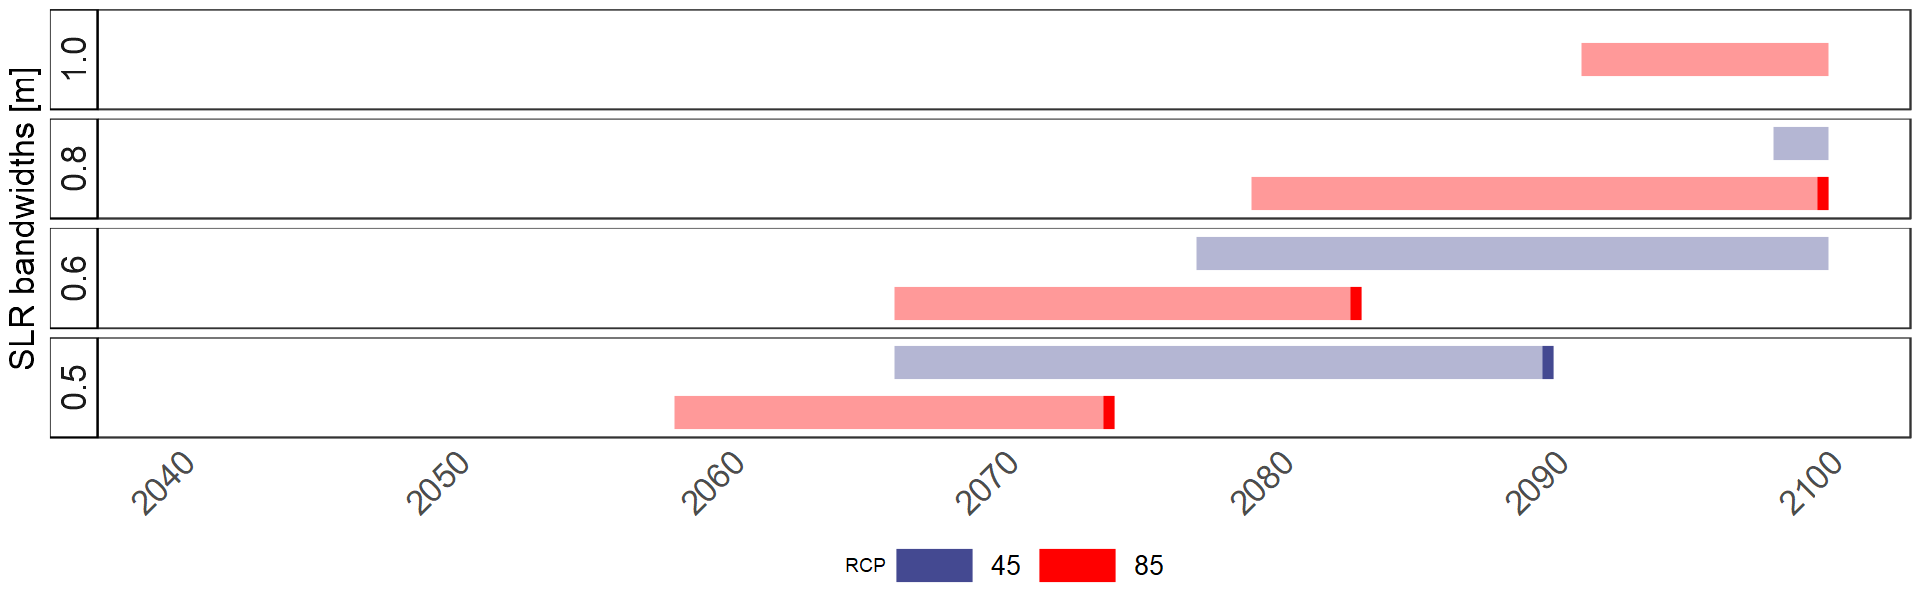

In [206]:
options(repr.plot.width = 16, repr.plot.height = 5)
print(slr_thresholds)